# Let's create some simple fake data

In [292]:
import numpy as np
import pandas as pd
import matplotlib
%matplotlib inline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

## For the Crosstabs Example

Let's generate some fake data:

In [384]:
def gimme_data():
    
    n = 500
    k = 100
    df = pd.DataFrame()
    ids = np.arange(n)
    np.random.shuffle(ids)
    df['entity_id'] = ids
    
    # ===== Underlying features ====== 
    
    # age is random
    df['age'] = np.random.randn(len(df)) * 15 + 45
    df.loc[df.age<0,'age'] = 1.0
    
    # gender is random
    df['gender_female'] = np.random.binomial(1, 0.6, len(df))
    
    # incident rate is random, but bi-modal
    switch = (np.random.randn(len(df)) > 0.2).astype(float)
    df['incident_rate'] = np.random.beta(5,2,len(df)) * switch + np.random.beta(1,5,len(df)) * (1-switch)
    
    # some people have a rare mutation
    df['random_feature_1'] = (np.random.randn(len(df)) > .5).astype(float)
    
    # ====== Actual risk ======
    
    # we have a latent score that determines actual risk
    df['latent_score'] = 0

    # every 30 years of age adds a risk point
    df.loc[:,'latent_score'] += df['age'] / 30

    # being male adds 1 risk points
    df.loc[df.gender_female==0, 'latent_score'] = df.loc[df.gender_female==0, 'latent_score'] + 2

    # incident rate * 2 for risk
    df['latent_score'] = df['latent_score'] + df['incident_rate'] * 2

    # if you're young, female, and have the rare mutation, you're at very high risk
    small_group = (df.age<25)&(df.gender_female==1)&(df.random_feature_1==1)
    df.loc[small_group, 'latent_score'] = df.loc[small_group, 'latent_score'] + 25

    # remember a cutoff - above this, you're positive (90th percentile
    cutoff = np.percentile(df.latent_score, q=90)

    # make some noooooise
    df['latent_score'] = df['latent_score'] + np.random.randn(len(df)) * 1
    
    # convert latent score to true label
    df['true_label'] = df['latent_score'] > cutoff
    del df['latent_score']
    
    # ===== Distracting Features =====
    
    for idx in range(2, 15):
        df['random_feature_%d'%idx] = ((np.random.randn(len(df)) * np.random.rand()*5 + np.random.randn()*5) > 2).astype(float)
        
    # some binary ones
    for idx in range(16, 30):
        df['random_feature_%d'%idx] = np.random.randn(len(df)) * np.random.rand()*5 + np.random.randn()*5
        
    # some boring correlates of age
    for idx in range(31, 60):
        df['random_feature_%d'%idx] = df['age'] + np.random.rand()*20 + np.random.rand()*100 +\
                                                  np.random.randn(len(df))*10
    # some boring correlates of gender
    for idx in range(61, 90):
        df['random_feature_%d'%idx] = df['gender_female'] + np.random.randn(len(df)) * np.random.rand()*5
        
    df = df[['entity_id','age','gender_female','incident_rate','true_label'] + 
            [c for c in df.columns if c.startswith('random')]]
        
    return df

#### Generate train and test set

In [402]:
train = gimme_data()
test = gimme_data()

In [403]:
train.true_label.value_counts()

False    419
True      81
Name: true_label, dtype: int64

In [404]:
test.true_label.value_counts()

False    429
True      71
Name: true_label, dtype: int64

#### Let's see if the interaction term made it through:

In [409]:
small_group = (train.age<25)&(train.gender_female==1)&(train.random_feature_1==1)
train[small_group].true_label.value_counts()

True    8
Name: true_label, dtype: int64

In [410]:
small_group = (test.age<25)&(test.gender_female==1)&(test.random_feature_1==1)
test[small_group].true_label.value_counts()

True    10
Name: true_label, dtype: int64

Yup!

### Fit and Predict with an RF

In [411]:
rf = RandomForestClassifier(n_estimators=200)
rf.fit(X=train.drop(['entity_id','true_label'],1),
       y=train['true_label'])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=200, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [412]:
preds = rf.predict_proba(test.drop(['entity_id','true_label'],1))

#### Just making sure that the RF can do something sensible: 

In [413]:
fpr, tpr, _ = roc_curve(y_true=test.true_label, y_score=preds[:,1])

In [414]:
roc_auc = auc(fpr, tpr)

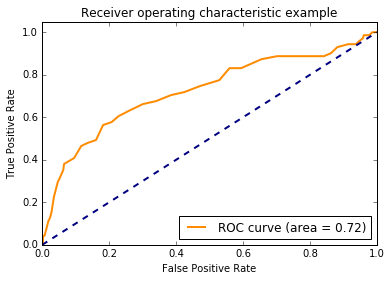

In [415]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

Looking alright.

In [416]:
test['score'] = preds[:,1]

In [417]:
test = test.sort_values(by='score', ascending=False)

In [419]:
test.head(10)

,entity_id,age,gender_female,incident_rate,true_label,random_feature_1,random_feature_2,random_feature_3,random_feature_4,random_feature_5,...,random_feature_81,random_feature_82,random_feature_83,random_feature_84,random_feature_85,random_feature_86,random_feature_87,random_feature_88,random_feature_89,score
256,246,45.707206,0,0.936189,False,0.0,0.0,0.0,1.0,0.0,...,1.604414,-3.259050,-1.907094,-3.194122,5.667859,-1.803107,0.597377,0.131608,2.221849,0.610
385,115,69.079261,0,0.973462,True,1.0,0.0,0.0,1.0,0.0,...,0.042844,-0.121097,-0.019635,-0.685809,-2.677701,2.040171,-0.126061,-0.249940,-3.261983,0.600
262,341,64.501325,0,0.876714,True,0.0,1.0,0.0,1.0,0.0,...,-0.889955,3.308929,-1.094386,3.820828,-1.493890,-3.059079,-1.554068,-0.264483,-1.483651,0.590
347,67,57.689446,0,0.890024,True,0.0,0.0,0.0,1.0,0.0,...,1.698292,-2.198866,0.312003,1.420848,-2.711358,-1.819957,-0.011389,-0.126452,-1.449900,0.565
275,168,30.877582,0,0.839481,False,0.0,1.0,0.0,1.0,0.0,...,1.438087,-0.301900,-1.079290,-2.121427,-6.733863,-2.015317,1.256779,0.106049,-3.229138,0.560
218,80,46.918857,0,0.821401,False,1.0,0.0,0.0,1.0,0.0,...,0.223053,2.062282,-5.859959,5.135702,4.401903,-0.847833,-0.343842,0.400157,2.798165,0.550
369,183,65.139218,0,0.176374,False,0.0,1.0,0.0,1.0,0.0,...,-0.201271,3.949461,-3.950919,1.108758,7.673945,1.958801,-0.390058,0.068962,1.105786,0.545
166,153,23.121496,0,0.835610,True,0.0,0.0,0.0,1.0,0.0,...,-1.619812,0.308895,0.046728,-4.741117,0.472311,0.870932,-0.997469,-0.015326,5.003751,0.545
333,305,80.173084,0,0.352738,True,0.0,0.0,0.0,1.0,0.0,...,-1.449521,-0.736680,-1.384991,6.199024,-4.105965,2.830056,0.019276,-0.322225,-8.655330,0.545
497,390,40.755420,0,0.871950,False,0.0,1.0,0.0,1.0,0.0,...,-2.318051,1.448330,0.961425,-0.533420,-0.751356,4.055057,-0.304116,-0.330331,-6.239099,0.545


But didn't pick up on the interaction term.

In [420]:
# rearrange columns a bit
test = test[['entity_id','true_label','score'] + [c for c in test.columns if c not in ['entity_id','true_label','score']]]

In [422]:
test.to_csv('test_data.csv', index=False)